<a href="https://colab.research.google.com/github/dungdt-infopstats/TV-command-synthesis/blob/main/src_prototype/Phase2_VCTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# F5-TTS
!pip install -q f5-tts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 69.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24

# VCTK

In [1]:
# Reference Speech
!gdown 1G5APBDW_BlWAyXW_76RO24-wK6XqWkNe --quiet
# Reference Meta (including Text)
!gdown 1eJ7migpI5HXW_ZsAdUnY2S7WL-cwLG6e --quiet

In [2]:
!unzip -q vctk_ref_audio.zip
!unzip -q vctk_ref_json.zip

# Flow

In [3]:
import os
from pydub import AudioSegment
from tqdm import tqdm

def add_silence_to_wav(input_dir, output_dir, silence_duration_ms=1000):
    # Tạo thư mục output nếu chưa tồn tại
    os.makedirs(output_dir, exist_ok=True)

    # Lấy danh sách file .wav
    wav_files = [f for f in os.listdir(input_dir) if f.lower().endswith(".wav")]

    # Loop qua danh sách file với tqdm
    for filename in tqdm(wav_files, desc="Processing WAV files"):
        filepath = os.path.join(input_dir, filename)

        # Load audio
        audio = AudioSegment.from_wav(filepath)

        # Tạo đoạn silence
        silence = AudioSegment.silent(duration=silence_duration_ms)

        # Ghép audio + silence
        padded_audio = audio + silence

        # Lưu file mới
        output_path = os.path.join(output_dir, filename)
        padded_audio.export(output_path, format="wav")

# Ví dụ chạy
add_silence_to_wav("audio", "pad_audio", silence_duration_ms=1000)


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):
Processing WAV files: 100%|██████████| 1080/1080 [00:01<00:00, 819.89it/s]


In [9]:
import os
import shutil
import librosa

def filter_audio_json(
    audio_dir,
    json_dir,
    output_audio_dir,
    output_json_dir,
    min_duration=1.0,
    max_duration=12.0,
    reset_output=False
):
    """
    Lọc bỏ các file audio có độ dài < min_duration hoặc > max_duration
    và đồng bộ file JSON cùng tên.

    Args:
        audio_dir (str): Thư mục chứa audio input.
        json_dir (str): Thư mục chứa json input.
        output_audio_dir (str): Thư mục chứa audio output.
        output_json_dir (str): Thư mục chứa json output.
        min_duration (float): Ngưỡng thời lượng tối thiểu (giây).
        max_duration (float): Ngưỡng thời lượng tối đa (giây).
        reset_output (bool): Nếu True thì xóa toàn bộ dữ liệu trong output dirs trước khi copy.
    """
    # reset output dirs nếu cần
    if reset_output:
        if os.path.exists(output_audio_dir):
            shutil.rmtree(output_audio_dir)
        if os.path.exists(output_json_dir):
            shutil.rmtree(output_json_dir)

    os.makedirs(output_audio_dir, exist_ok=True)
    os.makedirs(output_json_dir, exist_ok=True)

    kept, too_short, too_long, errors = 0, 0, 0, 0

    for file in os.listdir(audio_dir):
        if file.endswith((".wav", ".mp3", ".flac")):  # lọc định dạng audio
            audio_path = os.path.join(audio_dir, file)
            try:
                y, sr = librosa.load(audio_path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)

                if min_duration <= duration <= max_duration:
                    # copy audio
                    shutil.copy(audio_path, os.path.join(output_audio_dir, file))
                    kept += 1

                    # copy json nếu tồn tại
                    json_file = os.path.splitext(file)[0] + ".json"
                    json_path = os.path.join(json_dir, json_file)
                    if os.path.exists(json_path):
                        shutil.copy(json_path, os.path.join(output_json_dir, json_file))
                elif duration < min_duration:
                    too_short += 1
                else:
                    too_long += 1
            except Exception as e:
                print(f"Lỗi khi đọc {file}: {e}")
                errors += 1

    print(f"✅ Hoàn thành lọc audio + json.")
    print(f"   - Giữ lại: {kept}")
    print(f"   - Loại (quá ngắn): {too_short}")
    print(f"   - Loại (quá dài): {too_long}")
    print(f"   - Lỗi khi xử lý: {errors}")


In [20]:
filter_audio_json(
    audio_dir="pad_audio",
    json_dir="json",
    output_audio_dir="filtered_audio",
    output_json_dir="filtered_json",
    max_duration=12.0,
    reset_output=True
)


✅ Hoàn thành lọc audio + json.
   - Giữ lại: 1077
   - Loại (quá ngắn): 0
   - Loại (quá dài): 3
   - Lỗi khi xử lý: 0


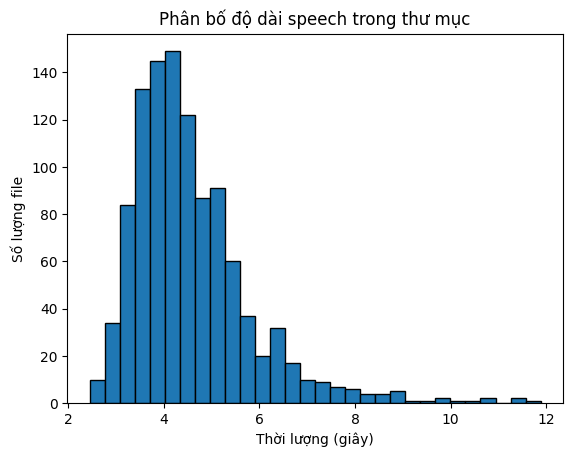

In [1]:
import os
import librosa
import matplotlib.pyplot as plt

# Đường dẫn tới thư mục chứa audio
audio_dir = "/content/filtered_audio"

durations = []

# Lặp qua các file audio trong thư mục
for file in os.listdir(audio_dir):
    if file.endswith((".wav", ".mp3", ".flac")):  # lọc định dạng audio
        file_path = os.path.join(audio_dir, file)
        try:
            y, sr = librosa.load(file_path, sr=None)  # load với sampling rate gốc
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)
        except Exception as e:
            print(f"Không đọc được file {file}: {e}")

# Vẽ histogram phân bố độ dài
plt.hist(durations, bins=30, edgecolor="black")
plt.xlabel("Thời lượng (giây)")
plt.ylabel("Số lượng file")
plt.title("Phân bố độ dài speech trong thư mục")
plt.show()


In [2]:
import os
import json
import soundfile as sf
import pandas as pd
import random
import ast
import numpy as np
import uuid
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
from pathlib import Path
import time
from typing import Any, List
from importlib.resources import files
from f5_tts.api import F5TTS

class ReferenceCache:
    def __init__(self, audio_folder_path: str, json_folder_path: str):
        self.audio_folder_path = Path(audio_folder_path)
        self.json_folder_path = Path(json_folder_path)
        self._audio_files = None
        self._json_files = None
        self._ref_texts = {}

    @property
    def audio_files(self):
        if self._audio_files is None:
            self._audio_files = [f for f in self.audio_folder_path.iterdir() if f.is_file()]
        return self._audio_files

    @property
    def json_files(self):
        if self._json_files is None:
            self._json_files = [f for f in self.json_folder_path.iterdir() if f.suffix == '.json']
        return self._json_files

    def get_ref_text(self, json_path: Path) -> str:
        if str(json_path) not in self._ref_texts:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                self._ref_texts[str(json_path)] = data.get('text', '')
        return self._ref_texts[str(json_path)]

    def sample_reference(self, target_len: int):
      # 1. Random 30 json files
      sampled_jsons = random.sample(self.json_files, min(30, len(self.json_files)))

      # 2. Tính độ dài và khoảng cách
      candidates = []
      for json_file in sampled_jsons:
          ref_text = self.get_ref_text(json_file)
          ref_len = len(ref_text.split())
          diff = abs(ref_len - target_len)
          candidates.append((diff, json_file, ref_text))

      # 3. Sort theo khoảng cách từ nhỏ -> lớn
      candidates.sort(key=lambda x: x[0])

      # 4. Lấy 5 file gần nhất
      top_candidates = candidates[:5]

      # 5. Random chọn trong top 5
      _, json_file, ref_text = random.choice(top_candidates)
      ref_id = json_file.stem
      audio_file = os.path.join(self.audio_folder_path, f"{ref_id}.wav")
      return ref_id, audio_file, ref_text


In [3]:
import os
import json
import soundfile as sf
import pandas as pd
import random
import ast
import numpy as np
import uuid
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
from pathlib import Path
import time
from typing import Any, List
from importlib.resources import files
from f5_tts.api import F5TTS

class SpeechSynthesis:
  def __init__(self, ref_folder_path, json_folder_path, num_workers):
    self.ref_folder_path = ref_folder_path
    self.json_folder_path = json_folder_path
    self.num_workers = num_workers

  def load_model(self):
    f5tts = F5TTS(device = 'cuda')
    return f5tts


  def audio_generate(self, command: str, model, ref_file: str = "", ref_text: str = ""):
      wav, sr, spec = model.infer(
          ref_file=ref_file,
          ref_text=ref_text,
          gen_text=command,
          seed=None,
      )
      return wav, sr, spec

  def process_single_command(self, row: pd.Series, ref_cache: ReferenceCache, export_path: str, model: Any):
    try:
        # --- Xác định target_len ---
        target_len = len(row['text'].split())

        if pd.notna(row['segments']) and row['segments'] not in [None, "", "nan"]:
            seg_list = ast.literal_eval(row['segments'])
            if isinstance(seg_list, list) and len(seg_list) > 0:
                seg_lens = []
                for seg in seg_list:
                    try:
                        # lấy text trong segment
                        seg_text = list(seg.values())[0]
                        seg_lens.append(len(seg_text.split()))
                    except Exception:
                        continue
                if len(seg_lens) > 0:
                    target_len = int(np.mean(seg_lens))

        # --- Chọn reference phù hợp ---
        ref_id, ref_speech_path, ref_text = ref_cache.sample_reference(target_len)

        # --- Generate full audio ---
        wav, sr, _ = self.audio_generate(row['text'], model, ref_speech_path, ref_text)

        cur_id = row['id']
        cmd_path = Path(export_path) / f"{row['type']}_{cur_id}"
        cmd_path.mkdir(parents=True, exist_ok=True)

        # Save full audio
        sf.write(cmd_path / f"{row['type']}_{cur_id}_full.wav", wav, sr)

        type_segments = {}
        text_segments = {}

        # --- Generate từng segment ---
        if pd.notna(row['segments']) and row['segments'] not in [None, "", "nan"]:
            seg_list = ast.literal_eval(row['segments'])
            for count, seg in enumerate(seg_list):
                key = list(seg.keys())[0]
                seg[key] = seg[key] + ",  "
                seg_wav, seg_sr, _ = self.audio_generate(seg[key], model, ref_speech_path, ref_text)
                sf.write(cmd_path / f"{row['type']}_{cur_id}_seg_{count}.wav", seg_wav, seg_sr)

                list_key = list(seg.keys())
                type_segments[list_key[0]] = seg[list_key[1]] if len(list_key) > 1 else ""
                text_segments[list_key[0]] = seg[list_key[0]]

        # --- Lưu metadata JSON ---
        json_template = {
            "id": cur_id,
            "type": row['type'],
            "command": row['text'],
            "sampling_rate": sr,
            "num_segments": len(type_segments),
            "type_segments": type_segments,
            "text_segments": text_segments,
            "ref_id": ref_id,
            "ref_file": ref_speech_path,
            "ref_text": ref_text
        }
        with open(cmd_path / f"{row['type']}_{cur_id}.json", 'w', encoding='utf-8') as f:
            json.dump(json_template, f, ensure_ascii=False, indent=2)

        return json_template

    except Exception as e:
        print(f"Failed to process: {row['text']}, error: {e}")
        return None



  def worker_task(self, rows: List[pd.Series], ref_folder: str, json_folder: str, export_path: str):
      # Mỗi worker load model riêng
      model = self.load_model()
      ref_cache = ReferenceCache(ref_folder, json_folder)
      results = []
      for row in rows:
          res = self.process_single_command(row, ref_cache, export_path, model)
          if res:
              results.append(res)
      return results

  def command_synthesis_pipeline_multi_model(
    self,
    text_command,
    export_path
  ):
    start_time = time.time()
    os.makedirs(export_path, exist_ok=True)

    if self.num_workers is None:
        self.num_workers = min(mp.cpu_count(), 4)  # Giới hạn số model load

    # Chia dữ liệu thành N phần, mỗi worker xử lý riêng
    chunks = np.array_split(text_command, self.num_workers)

    all_results = []
    with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
        futures = [
            executor.submit(self.worker_task, chunk.to_dict('records'), self.ref_folder_path, self.json_folder_path, export_path)
            for chunk in chunks
        ]
        for i, future in enumerate(futures):
            res_list = future.result()
            all_results.extend(res_list)
            print(f"Worker {i+1} done ({len(res_list)} items)")

    print(f"Pipeline finished in {time.time() - start_time:.2f}s")
    return pd.DataFrame(all_results)



In [4]:
import gdown

gid = '19PQWDZVvj30y6WuIkEGi_ZFKmeKNDQi2'
url = f"https://drive.google.com/uc?id={gid}"

output = gdown.download(url, quiet=False)  # output sẽ là tên file đã tải

Downloading...
From: https://drive.google.com/uc?id=19PQWDZVvj30y6WuIkEGi_ZFKmeKNDQi2
To: /content/part_1.zip
100%|██████████| 57.5k/57.5k [00:00<00:00, 3.27MB/s]


In [31]:
!unzip -q {output}

In [5]:
import shutil

param = {
    'ref_folder_path': "filtered_audio",
    'json_folder_path': "filtered_json",
    'num_workers': 4,
}

csv_folder = f'{os.path.splitext(output)[0]}'
export_folder = 'synthesis_command'

def main(export_folder):
  os.makedirs(export_folder, exist_ok=True)
  list_speech_df = []
  speech_synthesis = SpeechSynthesis(**param)
  for csv_file in os.listdir(csv_folder):
    if csv_file.endswith('.csv'):
      csv_path = os.path.join(csv_folder, csv_file)
      df = pd.read_csv(csv_path)
    else:
      continue

    name = os.path.splitext(csv_file)[0]
    export_path = f'{export_folder}/synthesis_command_{name}'
    os.makedirs(export_path, exist_ok=True)
    df_res = speech_synthesis.command_synthesis_pipeline_multi_model(df, export_path=export_path)
    shutil.make_archive(export_path, 'zip', export_path)
    list_speech_df.append(df_res)

    df_path = os.path.join(export_path, f'synthesis_command_{name}.csv')
    df.to_csv(df_path, index=False)

  list_speech_df = pd.concat(list_speech_df)
  list_speech_df.to_csv('synthesis_command.csv', index=False)

In [ ]:
if __name__ == '__main__':
  main(export_folder = export_folder)

/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Download Vocos from huggingface charactr/vocos-mel-24khz
Download Vocos from huggingface charactr/vocos-mel-24khz
Download Vocos from huggingface charactr/vocos-mel-24khz
Download Vocos from huggingface charactr/vocos-mel-24khz


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



vocab :  /usr/local/lib/python3.12/dist-packages/f5_tts/infer/examples/vocab.txt
token :  custom
model :  /root/.cache/huggingface/hub/models--SWivid--F5-TTS/snapshots/84e5a410d9cead4de2f847e7c9369a6440bdfaca/F5TTS_v1_Base/model_1250000.safetensors 


vocab :  /usr/local/lib/python3.12/dist-packages/f5_tts/infer/examples/vocab.txt
token :  custom
model :  /root/.cache/huggingface/hub/models--SWivid--F5-TTS/snapshots/84e5a410d9cead4de2f847e7c9369a6440bdfaca/F5TTS_v1_Base/model_1250000.safetensors 


vocab :  /usr/local/lib/python3.12/dist-packages/f5_tts/infer/examples/vocab.txt
token :  custom
model :  /root/.cache/huggingface/hub/models--SWivid--F5-TTS/snapshots/84e5a410d9cead4de2f847e7c9369a6440bdfaca/F5TTS_v1_Base/model_1250000.safetensors 


vocab :  /usr/local/lib/python3.12/dist-packages/f5_tts/infer/examples/vocab.txt
token :  custom
model :  /root/.cache/huggingface/hub/models--SWivid--F5-TTS/snapshots/84e5a410d9cead4de2f847e7c9369a6440bdfaca/F5TTS_v1_Base/model_1250000.safete

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

gen_text 0 set the volume to maximum


Generating audio in 1 batches...
Using custom reference text...

ref_text   Being involved at that level is like an addiction. 
gen_text 0 change the channel to CITV and mute the TV


Generating audio in 1 batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Converting audio...
Using custom reference text...

ref_text   This season has been great for me, it's been an experience. 
gen_text 0 I watched 'Klaus' last weekend and really enjoyed the animation.


Generating audio in 1 batches...
Converting audio...




  0%|          | 0/1 [00:00<?, ?it/s]

Using custom reference text...

ref_text   She has a little boy. 
gen_text 0 Rate this show 5 stars, the weather is so unpredictable lately.


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.04s/it]


Converting audio...
Using custom reference text...

ref_text   Certainly, in terms of league position, we must be favourites. 
gen_text 0 Have you heard Snoop Dogg's song 'Deep Cover'? It's such a classic.


Generating audio in 1 batches...




100%|██████████| 1/1 [00:09<00:00,  9.59s/it]

100%|██████████| 1/1 [00:09<00:00,  9.62s/it]



100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


Converting audio...
Converting audio...
Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   She has a little boy. 
Using custom reference text...

ref_text   We haven't finished the complaints procedure. 
gen_text 0 Rate this show 5 stars,,


Generating audio in 1 batches...
gen_text 0 search on Amazon Music for Drake


Generating audio in 1 batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom reference text...

ref_text   Things fall a little flat elsewhere, however. 



  0%|          | 0/1 [00:00<?, ?it/s]

gen_text 0 Did you see the new movie trailers? Go to channel Syfy and set brightness to 75, then let's talk about our weekend plans.


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


Converting audio...
Using custom reference text...

ref_text   She can scoop these things into three red bags, and we will go meet her Wednesday at the train station. 
gen_text 0 I remember enjoying 'Rush Hour 3' when it first came out; it always makes me laugh.


Generating audio in 1 batches...




100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   She has a little boy. 
gen_text 0 the weather is,


Generating audio in 1 batches...


100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Converting audio...
Using custom reference text...

ref_text   That argument has been won. 
gen_text 0 show the TV guide


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:09<00:00,  9.41s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   Things fall a little flat elsewhere, however. 
gen_text 0 Did you see the new movie trailers? ,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


Converting audio...
Using custom reference text...

ref_text   The award to Senator Mitchell was announced by the Foreign Office. 
gen_text 0 The Beach Boys' song 'Mona' is perfect for a chill evening at home.


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   She has a little boy. 
gen_text 0 so unpredictable lately.,


Generating audio in 1 batches...


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


Converting audio...
Using custom reference text...

ref_text   George is on a two-day visit to Scotland.). 
gen_text 0 Search on Twitch for Yu-Gi-Oh! 3D: Bonds Beyond Time, did you see the game last night?


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   Things fall a little flat elsewhere, however. 
gen_text 0 Go to channel Syfy and set brightness to 75, ,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.87s/it]


Converting audio...
Using custom reference text...

ref_text   That comes at a cost.). 
gen_text 0 set picture mode to Netflix


Generating audio in 1 batches...




100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


Converting audio...
Using custom reference text...

ref_text   I lost my head. 
gen_text 0 Skip to next episode, I really need to finish that project.


Generating audio in 1 batches...


100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   George is on a two-day visit to Scotland.). 
gen_text 0 Search on Twitch for Yu-Gi-Oh! 3D: Bonds Beyond Time,,


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   Things fall a little flat elsewhere, however. 
gen_text 0 then let's talk about our weekend plans.,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


Converting audio...
Using custom reference text...

ref_text   It needs a team approach. 
gen_text 0 increase the volume on Bilibili


Generating audio in 1 batches...




100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   I lost my head. 
gen_text 0 Skip to next episode,,


Generating audio in 1 batches...


100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   George is on a two-day visit to Scotland.). 
gen_text 0 did you see the game last night?,


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


Converting audio...
Using custom reference text...

ref_text   However, that is just for starters. 
gen_text 0 I'm thinking about dinner later. Set sound mode to stereo and put the TV in sleep mode before we decide.


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


Converting audio...
Using custom reference text...

ref_text   It was quite distressing for the crew. 
gen_text 0 switch to AV mode for WWE Network


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   I lost my head. 
gen_text 0 I really need,


Generating audio in 1 batches...


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


Converting audio...
Using custom reference text...

ref_text   We will pay their bills. 
gen_text 0 Mute the TV, I'm thinking of ordering pizza.


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   However, that is just for starters. 
gen_text 0 I'm thinking about dinner later. ,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


Converting audio...
Using custom reference text...

ref_text   He's on the wrong side. 
gen_text 0 set contrast to Blood Diamond


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   I lost my head. 
gen_text 0 to finish that project.,


Generating audio in 1 batches...


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   We will pay their bills. 
gen_text 0 Mute the TV,,


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   However, that is just for starters. 
gen_text 0 Set sound mode to stereo and put the TV in sleep mode ,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


Converting audio...
Using custom reference text...

ref_text   The letters are going out today. 
gen_text 0 I can't believe the game got canceled. Enable game mode for app: ESPN.


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


Converting audio...
Using custom reference text...

ref_text   Police could not say if the two incidents were connected. 
gen_text 0 what's playing now on app: Netflix, unmute the TV.


Generating audio in 1 batches...


100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   We will pay their bills. 
gen_text 0 I'm thinking of ordering pizza.,


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   However, that is just for starters. 
gen_text 0 before we decide.,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   The letters are going out today. 
gen_text 0 I can't believe the game got canceled.,


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


Converting audio...
Using custom reference text...

ref_text   Over time, with patience and precision, the terrorists will be pursued. 
gen_text 0 scroll up to movie: The Day, go to HDMI 1.


Generating audio in 1 batches...


100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


Converting audio...
Using custom reference text...

ref_text   I'm so pleased the show has won a prize. 
gen_text 0 Change audio language to English for The Guide to the Perfect Family, can you believe how fast this week went by?


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


Converting audio...
Using custom reference text...

ref_text   It was a surprising decision. 
gen_text 0 What time is our meeting? Disable game mode and go to channel Facebook Watch after we confirm.


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   The letters are going out today. 
gen_text 0 Enable game mode for app: ESPN.,


Generating audio in 1 batches...




100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


Converting audio...
Using custom reference text...

ref_text   Waiting times for these services are too long. 
gen_text 0 set sound mode to stereo, go to HDMI 2.


Generating audio in 1 batches...


100%|██████████| 1/1 [00:08<00:00,  8.08s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   I'm so pleased the show has won a prize. 
gen_text 0 Change audio language to English for The Guide to the Perfect Family,,


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:07<00:00,  7.98s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   It was a surprising decision. 
gen_text 0 What time is our meeting? ,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


Converting audio...
Using custom reference text...

ref_text   They might also be reviewed by their colleagues. 
gen_text 0 Have you seen that new restaurant downtown? Record this show: movie: The Grudge 3.


Generating audio in 1 batches...




100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


Converting audio...
Using custom reference text...

ref_text   Last year, it was ligaments in his knee. 
gen_text 0 what's playing now on TV channel: AMC+, set sound mode to surround.


Generating audio in 1 batches...


100%|██████████| 1/1 [00:08<00:00,  8.29s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   I'm so pleased the show has won a prize. 
gen_text 0 can you believe how fast this week went by?,


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   It was a surprising decision. 
gen_text 0 Disable game mode and go to channel Facebook Watch ,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   They might also be reviewed by their colleagues. 
gen_text 0 Have you seen that new restaurant downtown?,


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.67s/it]


Converting audio...
Using custom reference text...

ref_text   I can understand why they have gone. 
gen_text 0 Remind me when Tarzan starts, can you grab the remote? Mute the TV and skip intro for that Apple TV+ show.


Generating audio in 1 batches...


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


Converting audio...
Using custom reference text...

ref_text   Hopefully, we can learn from our mistakes. 
gen_text 0 Go to channel HBO Max / Max, have you finished that book I lent you?


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:06<00:00,  7.00s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   It was a surprising decision. 
gen_text 0 after we confirm.,


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   They might also be reviewed by their colleagues. 
gen_text 0 Record this show: movie: The Grudge 3.,


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   I can understand why they have gone. 
gen_text 0 Remind me when Tarzan starts,


Generating audio in 1 batches...


100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   Hopefully, we can learn from our mistakes. 
gen_text 0 Go to channel HBO Max / Max,,


Generating audio in 1 batches...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


Converting audio...
Using custom reference text...

ref_text   They are a different team at home. 
gen_text 0 I can't believe it snowed today. Set brightness to 50 and go to channel MTV, MTV2 while we watch the news.


Generating audio in 1 batches...





  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   Hopefully, we can learn from our mistakes. 
gen_text 0 Did you hear that funny joke? Turn on subtitles for app: Amazon Prime Video.


Generating audio in 1 batches...




100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


Converting audio...
Using cached preprocessed reference audio...
Using custom reference text...

ref_text   I can understand why they have gone. 
gen_text 0 can you grab the remote?,


Generating audio in 1 batches...


  0%|          | 0/1 [00:00<?, ?it/s]

In [1]:
!zip synthesis_command.zip /content/synthesis_command -r

  adding: content/synthesis_command/ (stored 0%)
  adding: content/synthesis_command/synthesis_command_commands_104/ (stored 0%)
  adding: content/synthesis_command/synthesis_command_commands_104/non_active_a10b7e7d/ (stored 0%)
  adding: content/synthesis_command/synthesis_command_commands_104/non_active_a10b7e7d/non_active_a10b7e7d.json (deflated 36%)
  adding: content/synthesis_command/synthesis_command_commands_104/non_active_a10b7e7d/non_active_a10b7e7d_full.wav (deflated 33%)
  adding: content/synthesis_command/synthesis_command_commands_104/non_active_f64c614f/ (stored 0%)
  adding: content/synthesis_command/synthesis_command_commands_104/non_active_f64c614f/non_active_f64c614f.json (deflated 37%)
  adding: content/synthesis_command/synthesis_command_commands_104/non_active_f64c614f/non_active_f64c614f_full.wav (deflated 27%)
  adding: content/synthesis_command/synthesis_command_commands_104/chain_active_9beab791/ (stored 0%)
  adding: content/synthesis_command/synthesis_command